In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#mycmap = ListedColormap(["blue","red","gold","green","purple","orange","pink","brown","gray"])
mycmap = ListedColormap(["blue","red", "gold"])
import plotly.graph_objects as go

### Data preparation

In [2]:
pixels, label = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
label = label.astype(int)
pixels = np.where(pixels / np.max(pixels) > 0.5, 1, 0).astype(int)

dataframe = { "label": label, "pixels": [px for px in pixels] }
df = pd.DataFrame(dataframe)

N = 1000
dataset = df[df["label"] <= 2] # select only 0, 1, 2 values
valSet = dataset[N:N+400]
dataset = dataset[0:N]
data = dataset["pixels"].to_list()
label = dataset["label"].to_list()

In [3]:
def sigmoid(x):
    """Compute the sigmoid activation function."""
    x = np.clip(x, -500, 500)  # Avoid overflow
    return 1 / (1 + np.exp(-x))

def hidden_to_visible(hidden, model):
    w = model.components_
    a = model.intercept_visible_
    prob_visible = sigmoid(np.dot(hidden, w) + a)
    v = (prob_visible > np.random.rand(*prob_visible.shape)).astype(int)
    return v

def visible_to_hidden(visible, model):
    w = model.components_
    b = model.intercept_hidden_
    prob_hidden = sigmoid(np.dot(w, visible) + b)
    h = (prob_hidden > np.random.rand(*prob_hidden.shape)).astype(int)
    return h

### Train RBM using sklearn

In [4]:
# Train RBM
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

"https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html"
model = BernoulliRBM(n_components=24, learning_rate=0.1, n_iter=400, verbose=0, random_state=0)
RBM_fit = model.fit(data, label)

# Extract the weights and biases
w = model.components_
a = model.intercept_visible_
b = model.intercept_hidden_

# Extract the hidden layer
#h = model.transform(data)
h =[]
for i,v in enumerate(data):
    hid = visible_to_hidden(v, model)
    h.append(hid)
h = np.array(h)
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(h)

### Standardize data and compute the PCA of the hidden

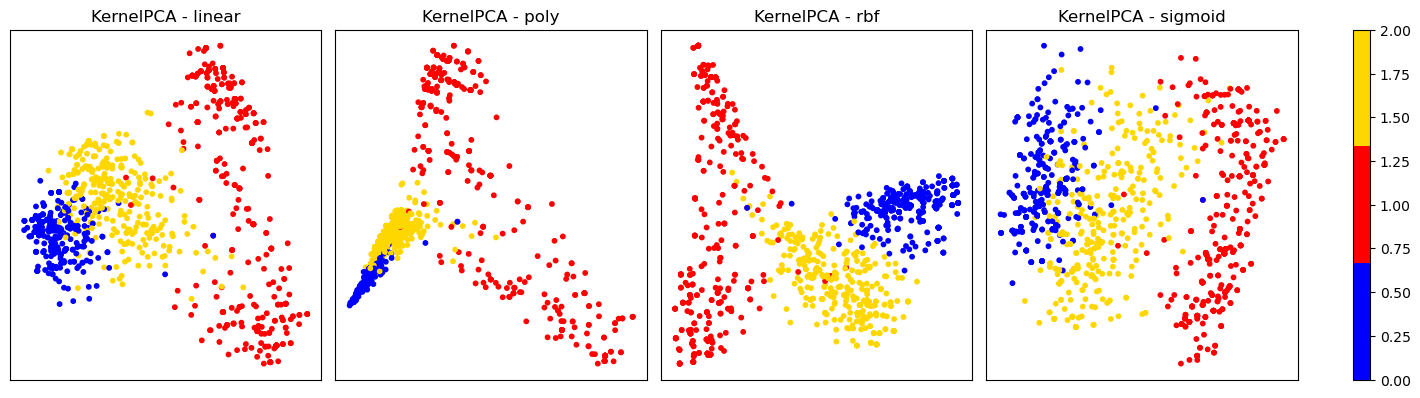

In [7]:
# Perform PCA (kernel='linear' for the usual PCA)

KERNEL = ['linear', 'poly', 'rbf', 'sigmoid']
fig, axs = plt.subplots(1, 4, figsize=(14, 4))

for i in range(len(KERNEL)):
    pca = KernelPCA(n_components=2, kernel=KERNEL[i], fit_inverse_transform=True, gamma=0.05)
    X_pca = pca.fit_transform(scaled_data)

    axs[i].scatter(X_pca[:, 0], X_pca[:, 1], c=label, cmap=mycmap, s=10)
    axs[i].set_title(f"KernelPCA - {KERNEL[i]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.tight_layout()
plt.colorbar(axs[0].collections[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()


In [8]:
# Perform PCA (kernel='linear' for the usual PCA)
pca = KernelPCA(n_components=3, kernel='linear', fit_inverse_transform=True)
X_pca = pca.fit_transform(scaled_data)

#print("Explained variance from the first 3 components:", np.sum(pca.explained_variance_ratio_))

fig = go.Figure(data=[go.Scatter3d(x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2], mode='markers',
				marker=dict(size=5, color=label, colorscale=mycmap.colors, opacity=0.8))])
fig.update_layout(width=800, height=800, margin=dict(l=0,r=0,b=0,t=0,pad=0))
fig.show()

---

### Energy calculation for each 3D-PCA space point
Projection from 3D (PCA space) to 24D (hidden space) and from 24D to 784D (visible space)

In [9]:
grid = np.linspace(-5, 5, 30)
xx, yy, zz = np.meshgrid(grid, grid, grid)

# generate h and v for each point in the grid
# apply inverse PCA and inverse scaler to find h
h_generated = scaler.inverse_transform(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]))
v_generated = hidden_to_visible(h_generated, model)

# Contrasting divergence using gibbs sampling
for _ in range(3):
    v_generated = model.gibbs(v_generated)

In [10]:
E = np.zeros(h_generated.shape[0])
for i in range(len(E)):
    v = v_generated[i,:]
    h = h_generated[i,:]
    E[i] = -np.dot(v, a) -np.dot(h, b) - np.dot(v, np.dot(h, w))

In [11]:
fig = go.Figure(data=go.Volume(
    x=xx.flatten(), y=yy.flatten(), z=zz.flatten(),
    value=E,
    #isomin=0.2,
    #isomax=0.7,
    opacity=0.05,
    surface_count=30,
    colorscale="Magma",
    reversescale=True,
    colorbar={"title": "Energy"}
    ))

fig.add_trace(go.Scatter3d(
    x=X_pca[:,0],
    y=X_pca[:,1],
    z=X_pca[:,2],
    mode="markers",
    marker=dict(
        size=3,
        color=label,
        colorscale=mycmap.colors,  # Use labels to color points
    ),
    name="Hidden Points"
))

fig.update_layout(width=800, height=800, title="Energy Landscape of RBM",
                  scene=dict(
                      xaxis_title="PCA0",
                      yaxis_title="PCA1",
                      zaxis_title="PCA2"
                  ))
fig.show()

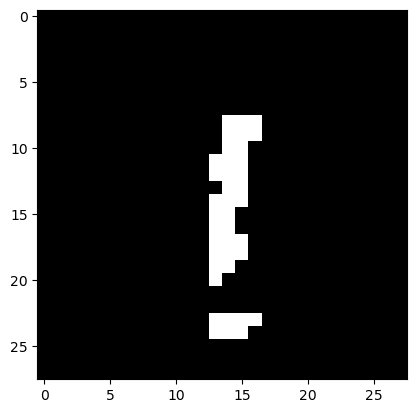

In [12]:
# Generation test
coordinates = np.array([[3, -1, -1]])
h_pick = pca.inverse_transform(coordinates)
v_pick = (scaler.fit_transform(hidden_to_visible(h_pick, model).reshape(-1, 1))).reshape(-1)
for _ in range(10):
    v_pick = model.gibbs(v_pick)

plt.imshow(np.reshape(v_pick, (28, 28)), cmap="gray")
plt.show()

----

## Classification test

In [13]:
def project(visible, model, pca):
    """
    This will return the 3D PCA representation of the hidden units in the input dataframe
    """
    hidden = visible_to_hidden(visible, model)  # get the hidden representation
    pca_proj = pca.transform(hidden.reshape(1, -1))[0]  # project the hidden into PCA space
    return pca_proj

def findClosestCluster(point, k):
    """
    This function will return the k-closest cluster for each point
    """
    minDist = [float("inf")]*k
    closestCluster = [-1]*k
    for i,sample in enumerate(X_pca):
        dist = np.linalg.norm(point - sample)             ## !!!! The metric in the space is not euclidean, so this is just an approx
        if dist < max(minDist):
            idx = minDist.index(max(minDist))
            minDist[idx] = dist
            closestCluster[idx] = label[i]
    return max(set(closestCluster), key = lambda x: (closestCluster.count(x),-closestCluster.index(x)))

def classify(point, model, pca, rep=1, kneigh=5):
    """
    This function will classify a given point based on its euclidean distance to the k-closest samples
    Since this approach is stochastic (the hidden representation of the visible points is different at every run due to the CD algorithm)
    We repeat the process _rep_ times and take the clusters that appears the most in those repetitions (majority voting)
    """
    res = []
    for j in range(rep):
        projected = project(point, model, pca)
        c = findClosestCluster(projected,kneigh)
        res.append(c)
    return max(set(res), key = lambda x: (res.count(x),-res.index(x)))

def computeAccuracy(valSet):
    """
    This function will compute the accuracy of the model on the validation set
    """
    clusters = [classify(point, rep = 5, kneigh = 15) for point in valSet["pixels"].values]
    acc = np.sum(clusters == valSet["label"].values)/len(clusters)
    return acc


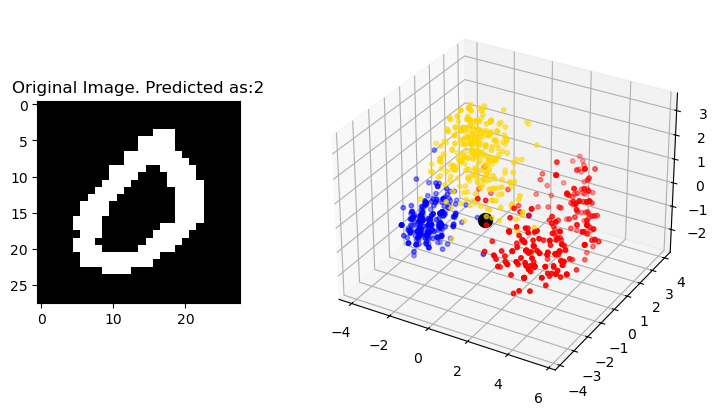

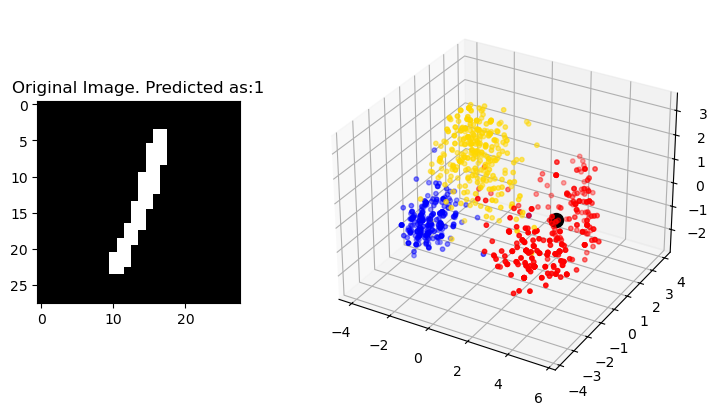

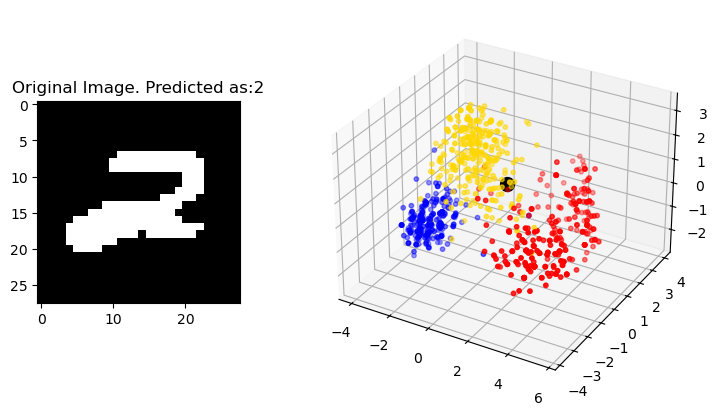

In [14]:
# let us apply this algorithm to a bunch of points in the validation set
for j in [3,4,5]:
    newSample = valSet.iloc[j,1]
    projected = project(newSample, model, pca)
    cluster = findClosestCluster(projected, 10)

    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(141) 
    ax1.imshow(newSample.reshape(28,28), cmap="gray")
    ax1.set_title("Original Image. Predicted as:"+str(cluster))
    ax2 = fig.add_subplot(projection='3d')
    ax2.scatter(projected[0], projected[1], projected[2], s = 100, c="black")
    ax2.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=label,s = 10, cmap=mycmap)
    plt.show()

In [15]:
for j in range(5):
    #print(f"Accuracy of the RBM classifier: ", computeAccuracy(valSet))
    pass

----

## Analysis of the energetic landscape

In [16]:
model = BernoulliRBM(n_components=24, learning_rate=0.1, n_iter=200, verbose=0, random_state=0)
RBM_fit = model.fit(data, label)

# Extract the weights and biases
w = model.components_
a = model.intercept_visible_
b = model.intercept_hidden_

h = model.transform(data)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(h)

data0 = scaled_data[np.where(np.array(label) == 0)]
data1 = scaled_data[np.where(np.array(label) == 1)]
data2 = scaled_data[np.where(np.array(label) == 2)]

### - Discrete case (Hamming path)

In [17]:
def hamming_path(init, fin):
    """ 
    This function takes in two points in a D-dimensional Manhattan space and return a Hamming path connecting those two points
    """
    init = np.array(init, dtype=int) 
    fin = np.array(fin, dtype =int)
    path = [init.copy()] 
    for i in range(len(init)):
        if init[i] != fin[i]:  
            init[i] = fin[i] 
            path.append(init.copy())  
    
    return path

data0 = h[np.where(np.array(label) == 0)]
data1 = h[np.where(np.array(label) == 1)]
data2 = h[np.where(np.array(label) == 2)]

Energetic gap:  58.88199061766442


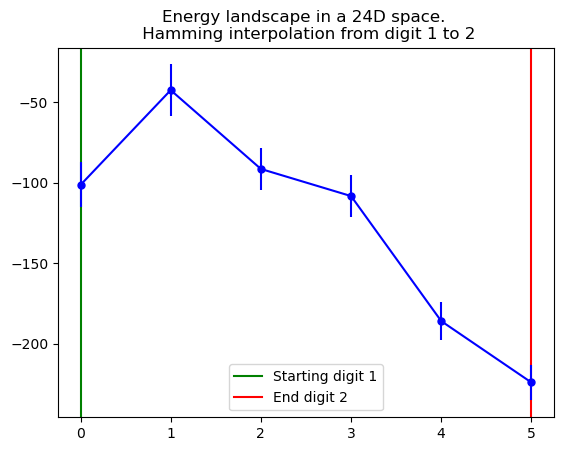

In [18]:
# choose a digit randomly
chosenDigit = (data0[np.random.randint(0, len(data0))],  data1[np.random.randint(0, len(data1))], data2[np.random.randint(0, len(data2))])

#choose the starting digit and the final digit
digitfrom = 1
digitto = 2

# build the "path" in the Hamming sense (from start to end modifying just a bit at each step)
line = hamming_path(chosenDigit[digitfrom], chosenDigit[digitto])
assert (np.all(line[0] == chosenDigit[digitfrom].astype(int)))
assert (np.all(line[-1] == chosenDigit[digitto].astype(int)))

# We will "extend" the path over the last point by adding a few points (again, a bit by step)
# If not interested, just let added=0
added = 0
idx = np.random.choice(list(range(24)), added, replace=False)
for k in range(added):
    new = line[-1].copy()
    if new[idx[k]] == 0:
        new[idx[k]] = 1
    elif new[idx[k]] == 1:
        new[idx[k]] = 0
    line.append(new)
assert(np.sum(line[-added-1]!=line[-1]) == added)

# start performing the hamming morphing
energiess = []
stds = []
for i in line:
    currentHidden = i
    en_tmp = np.zeros(500)       # for every point, average the energy over 500 points (?)
    for j in range(500):
        vis = hidden_to_visible(currentHidden, model)        # we are basically averaging over the visible produced by a fixed hidden
        en = -np.dot(vis, a) - np.dot(currentHidden, b) - np.dot(vis, np.dot(currentHidden, w))
        en_tmp[j] = en
    energiess.append(np.mean(en_tmp))
    stds.append(np.std(en_tmp))

highestEnergy = max(energiess)
minGap = highestEnergy-energiess[0]
print("Energetic gap: ", minGap)

plt.axvline(x = 0, c="green", label = f"Starting digit {digitfrom}")
plt.axvline(x = len(line)-1-added, c="red", label=f"End digit {digitto}")
plt.legend(loc="best")
plt.title(f"Energy landscape in a 24D space. \n Hamming interpolation from digit {digitfrom} to {digitto}")
plt.errorbar(list(range(len(line))), energiess, stds, markersize=5, marker="o", color="blue")
plt.show()

Now let's try to compute the average energetic gap for a given pair of digit:

In [19]:
# We'll start with 0 -> 1
minGap01 = []
rep = 5000

size0 = len(data0)
size1 = len(data1)
cartesianProduct = [(d0, d1) for d0 in data0 for d1 in data1]
indices = np.random.choice(range(size0*size1), rep, replace=False)
print(size0*size1)
for l in range(rep):
        chosenDigit = cartesianProduct[l]
      
        # build the "path" in the Hamming sense (from start to end modifying just a bit at each step)
        hidden0 = chosenDigit[0]
        hidden1 = chosenDigit[1]
        line = hamming_path(hidden0, hidden1)
        if(len(line) > 4):   
            assert (np.all(line[0] == hidden0.astype(int)))
            assert (np.all(line[-1] == hidden1.astype(int)))

            energiess = []
            stds = []
            for i in line:
                currentHidden = i
                en_tmp = np.zeros(200)
                for j in range(200):
                    vis = hidden_to_visible(currentHidden, model)
                    en = -np.dot(vis, a) - np.dot(currentHidden, b) - np.dot(vis, np.dot(currentHidden, w))
                    en_tmp[j] = en
                energiess.append(np.mean(en_tmp))
                stds.append(np.std(en_tmp))

            highestEnergy = max(energiess)
            minGap = highestEnergy-energiess[0]
            minGap01.append(minGap)
#minGap01 = np.array(minGap01)[np.where(np.array(minGap01) > 0.01)]

112893


KeyboardInterrupt: 

Avg energy gap 0-1:  111.23065207542102


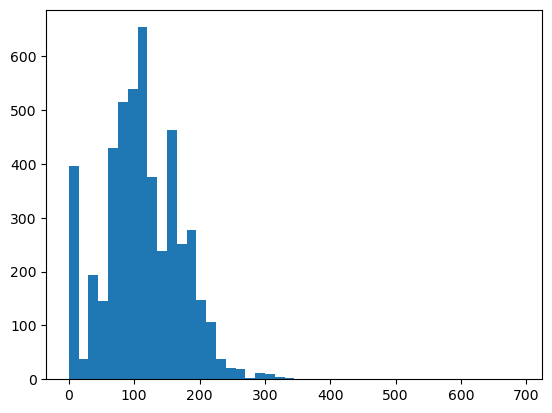

In [ ]:
print("Avg energy gap 0-1: ", np.mean(minGap01))
plt.hist(minGap01, bins = np.arange(0,700,15), alpha = 1, label = "0-1")
plt.show()

In [ ]:
minGap02 = []
size0 = len(data0)
size2 = len(data2)
cartesianProduct = [(d0, d2) for d0 in data0 for d2 in data2]
indices = np.random.choice(range(size0*size2), rep, replace=False)
print(size0*size2)
for l in range(rep):
        chosenDigit = cartesianProduct[l]
      
        # build the "path" in the Hamming sense (from start to end modifying just a bit at each step)
        hidden0 = chosenDigit[0]
        hidden1 = chosenDigit[1]
        line = hamming_path(hidden0, hidden1)
        if(len(line) > 4):   
            assert (np.all(line[0] == hidden0.astype(int)))
            assert (np.all(line[-1] == hidden1.astype(int)))

            energiess = []
            stds = []
            for i in line:
                currentHidden = i
                en_tmp = np.zeros(200)
                for j in range(200):
                    vis = hidden_to_visible(currentHidden, model)
                    en = -np.dot(vis, a) - np.dot(currentHidden, b) - np.dot(vis, np.dot(currentHidden, w))
                    en_tmp[j] = en
                energiess.append(np.mean(en_tmp))
                stds.append(np.std(en_tmp))

            highestEnergy = max(energiess)
            minGap = highestEnergy-energiess[0]
            minGap02.append(minGap)
#minGap02 = np.array(minGap02)[np.where(np.array(minGap02) > 0.01)]

101386


Avg energy gap 0-2:  97.56618205261829


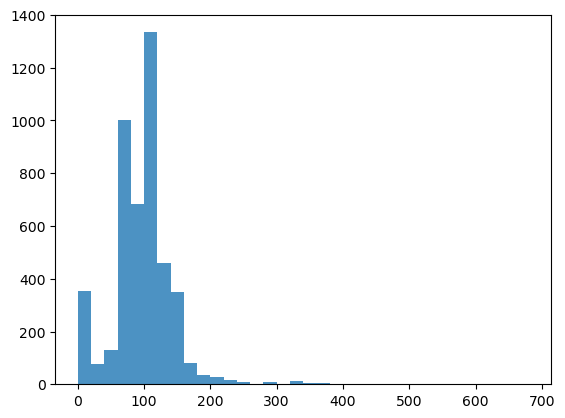

In [ ]:
print("Avg energy gap 0-2: ", np.mean(minGap02))
plt.hist(minGap02, bins = np.arange(0,700,20), alpha = 0.8, label = "0-1")
plt.show()

In [ ]:
minGap12 = []
size0 = len(data0)
size2 = len(data1)
cartesianProduct = [(d1, d2) for d1 in data1 for d2 in data2]
indices = np.random.choice(range(size1*size2), rep, replace=False)
print(size1*size2)
for l in range(rep):
        chosenDigit = cartesianProduct[l]
      
        # build the "path" in the Hamming sense (from start to end modifying just a bit at each step)
        hidden0 = chosenDigit[0]
        hidden1 = chosenDigit[1]
        line = hamming_path(hidden0, hidden1)
        if(len(line) > 4):   
            assert (np.all(line[0] == hidden0.astype(int)))
            assert (np.all(line[-1] == hidden1.astype(int)))

            energiess = []
            stds = []
            for i in line:
                currentHidden = i
                en_tmp = np.zeros(200)
                for j in range(200):
                    vis = hidden_to_visible(currentHidden, model)
                    en = -np.dot(vis, a) - np.dot(currentHidden, b) - np.dot(vis, np.dot(currentHidden, w))
                    en_tmp[j] = en
                energiess.append(np.mean(en_tmp))
                stds.append(np.std(en_tmp))

            highestEnergy = max(energiess)
            minGap = highestEnergy-energiess[0]
            minGap12.append(minGap)


131769


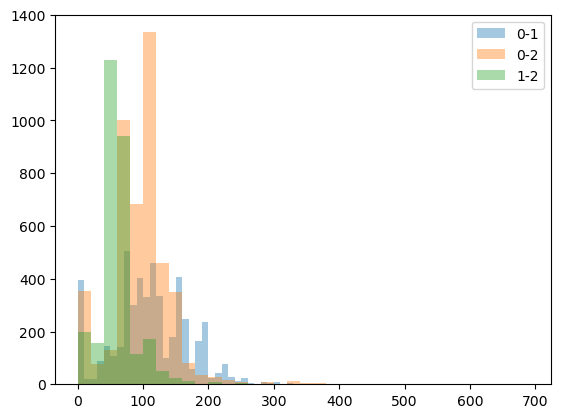

Avg energy gap 0-1:  111.23065207542102
Avg energy gap 0-2:  97.56618205261829
Avg energy gap 1-2:  61.49253541098134


In [ ]:
minGap12 = np.array(minGap12)[np.where(np.array(minGap12) > 0.01)]
plt.hist(minGap01, bins = np.arange(0,700,10), alpha = 0.4, label = "0-1")
plt.hist(minGap02, bins = np.arange(0,700,20), alpha = 0.4, label = "0-2")
plt.hist(minGap12, bins = np.arange(0,700,20),  alpha = 0.4, label = "1-2")
plt.legend(loc="best")
plt.show()

print("Avg energy gap 0-1: ", np.mean(minGap01))
print("Avg energy gap 0-2: ", np.mean(minGap02))
print("Avg energy gap 1-2: ", np.mean(minGap12))

### Continuous case

In [4]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from numba import prange

model = BernoulliRBM(n_components=20, learning_rate=0.1, n_iter=200, verbose=0, random_state=0)
RBM_fit = model.fit(data, label)
w = model.components_
a = model.intercept_visible_
b = model.intercept_hidden_

# In this specific case, we'll use the scaled data
h = []
for i,v in enumerate(data):
    hid = visible_to_hidden(v, model)
    h.append(hid)
h = np.array(h)

There are  311 digit 0s
There are  363 digit 1s
There are  326 digit 2s


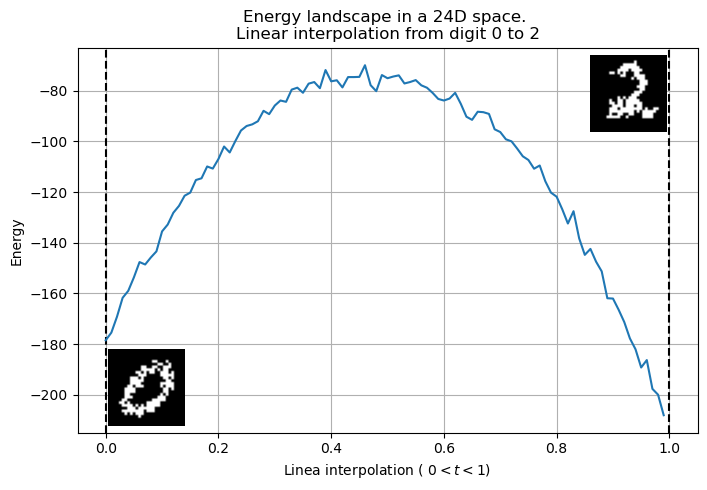

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

data0 = h[np.where(np.array(label) == 0)]
data1 = h[np.where(np.array(label) == 1)]
data2 = h[np.where(np.array(label) == 2)]

print("There are ", len(data0), "digit 0s")
print("There are ", len(data1), "digit 1s")
print("There are ", len(data2), "digit 2s")

chosenDigit = (data0[np.random.randint(0, len(data0))],  data1[np.random.randint(0, len(data1))], data2[np.random.randint(0, len(data2))])

digito = 2
digitfrom = 0

dfrom = chosenDigit[digitfrom]
dto = chosenDigit[digito]

def energyOnLine(dto, dfrom, steps=0.01):
    energiess = []
    steps = 0.01
    ranget = np.arange(0,1,steps)
    diff = dto - dfrom
    line = [dfrom + diff*t for t in ranget]
    for i in line:
        currentHidden = i
        en_tmp = np.zeros(20)
        for j in range(20):
            vis = hidden_to_visible(currentHidden, model)
            en = -np.dot(vis, a) - np.dot(currentHidden, b) - np.dot(np.dot(currentHidden, w), vis )
            en_tmp[j] = en
        energiess.append(np.mean(en_tmp))
    return energiess

energiess = energyOnLine(dto, dfrom)
fig, ax = plt.subplots(figsize=(8, 5))
ax.axvline(x=0, color='black', linestyle='--')
ax.axvline(x=1, color='black', linestyle='--')
ax.set_title(f"Energy landscape in a 24D space. \nLinear interpolation from digit {digitfrom} to {digito}")
ax.plot( np.arange(0,1,0.01), energiess)
ax.set_xlabel("Linea interpolation ( $0<t<1$)")
ax.set_ylabel("Energy")

visto = hidden_to_visible(dto, model)
visfrom = hidden_to_visible(dfrom, model)

inset_ax = inset_axes(ax, width="20%", height="20%", loc="lower left") 
inset_ax.imshow(visfrom.reshape(28,28), cmap="gray")
inset_ax.axis("off")  # Rimuove gli assi per l'immagine

inset_ax = inset_axes(ax, width="20%", height="20%", loc="upper right") 
inset_ax.imshow(visto.reshape(28,28), cmap="gray")
inset_ax.axis("off")  # Rimuove gli assi per l'immagine

ax.grid()
plt.show()


In [16]:
rep = 10000
size0, size1, size2 = len(data0), len(data1), len(data2)

minGap01 = []
cartesianProduct = [(d0, d1) for d0 in data0 for d1 in data1]
indices = np.random.choice(range(size0*size1), rep, replace=False)

for l in prange(rep):
        chosenDigit = cartesianProduct[l]
        # build the "path" in the Hamming sense (from start to end modifying just a bit at each step)
        hidden0 = chosenDigit[0]
        hidden1 = chosenDigit[1]

        energiess = energyOnLine(hidden1, hidden0, 0.01)

        minGap01.append(max(energiess)-energiess[0])

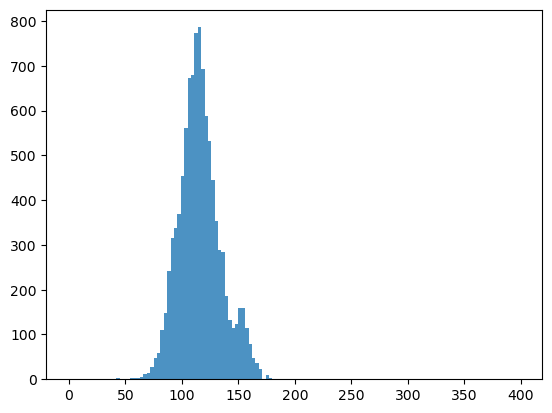

Avg energy gap 0-1: 116.0 +/- 0.2


In [19]:
plt.hist(minGap01, bins = np.arange(0,400,3), alpha = 0.8, label = "2-1")
plt.show()
print( f"Avg energy gap 0-1: {np.mean(minGap01):.1f} +/- {np.std(minGap01)/np.sqrt(len(minGap01)):.1f}" )

In [20]:
minGap02 = []
cartesianProduct = [(d2, d0) for d2 in data2 for d0 in data0]
indices = np.random.choice(range(size0*size2), rep, replace=False)

for l in range(rep):
        chosenDigit = cartesianProduct[l]
        hidden0 = chosenDigit[0]
        hidden1 = chosenDigit[1]

        energiess = energyOnLine(hidden1, hidden0, 0.01)
        minGap02.append(max(energiess)-energiess[0])
        #print("Energy gap: ", max(energiess)-energiess[0])

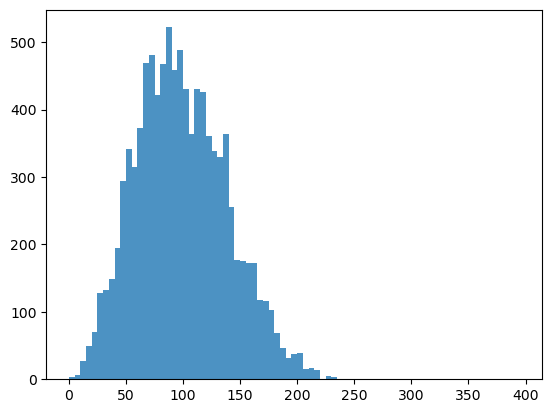

Avg energy gap 2-1: 99.0 +/- 0.4


In [21]:
plt.hist(minGap02, bins = np.arange(0,400,5), alpha = 0.8, label = "2-1")
plt.show()
print( f"Avg energy gap 2-1: {np.mean(minGap02):.1f} +/- {np.std(minGap02)/np.sqrt(len(minGap02)):.1f}" )

In [22]:
minGap12 = []
cartesianProduct = [(d1, d2) for d1 in data1 for d2 in data2]
indices = np.random.choice(range(size1*size2), rep, replace=False)

for l in range(rep):
        chosenDigit = cartesianProduct[l]
        hidden0 = chosenDigit[0]
        hidden1 = chosenDigit[1]

        energiess = energyOnLine(hidden1, hidden0, 0.01)
        minGap12.append(max(energiess)-energiess[0])
        #print("Energy gap: ", max(energiess)-energiess[0])

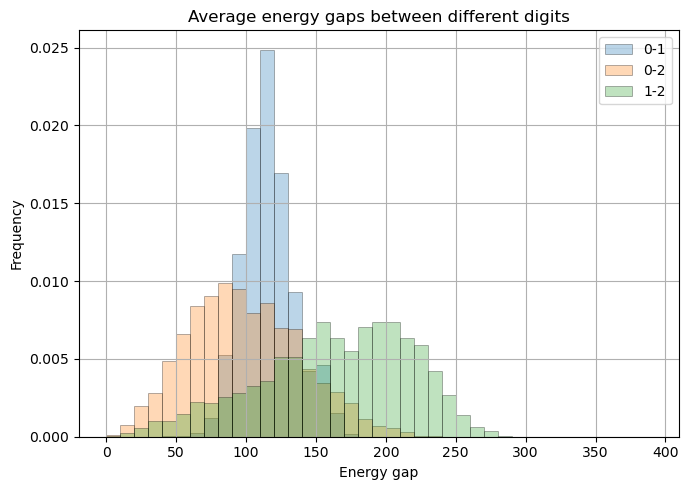

Avg energy gap 0-1: 116.0 +/- 0.2
Avg energy gap 0-2: 99.0 +/- 0.4
Avg energy gap 1-2: 163.5 +/- 0.5


In [24]:
fig, ax = plt.subplots(figsize=(7, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
ax.hist(minGap01, bins=np.arange(0, 400, 10), alpha=0.3, color=colors[0], edgecolor='black', linewidth=0.7, label="0-1", density=True)
ax.hist(minGap02, bins=np.arange(0, 400, 10), alpha=0.3, color=colors[1], edgecolor='black', linewidth=0.7, label="0-2", density=True)
ax.hist(minGap12, bins=np.arange(0, 400, 10), alpha=0.3, color=colors[2], edgecolor='black', linewidth=0.7, label="1-2", density=True)
ax.legend(loc="best")
ax.set_xlabel("Energy gap")
ax.set_ylabel("Frequency")
ax.set_title("Average energy gaps between different digits")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

print( f"Avg energy gap 0-1: {np.mean(minGap01):.1f} +/- {np.std(minGap01)/np.sqrt(len(minGap01)):.1f}" )
print( f"Avg energy gap 0-2: {np.mean(minGap02):.1f} +/- {np.std(minGap02)/np.sqrt(len(minGap02)):.1f}" )
print( f"Avg energy gap 1-2: {np.mean(minGap12):.1f} +/- {np.std(minGap12)/np.sqrt(len(minGap12)):.1f}" )

Avg energy gap 0-1:  201.86115195805738
Avg energy gap 0-2:  70.17776209436511
Avg energy gap 1-2:  183.2565104221503